# Modules import

In [2]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

import os

import PIL.Image

Data import

In [3]:
img_dircetory = os.path.join('..', 'data', 'Binary_model', 'Images', 'malaria', 'images')

In [4]:
images =  []

for image in os.listdir(img_dircetory):
    images.append(img_dircetory+'/'+image)

In [5]:
json_dircetory = os.path.join('..', 'data', 'Binary_model', 'Images', 'malaria')

In [6]:
training_json_directory = json_dircetory+'/'+os.listdir(json_dircetory)[0]

In [7]:
test_json_directory = json_dircetory+'/'+os.listdir(json_dircetory)[1]

In [8]:
training_json = pd.read_json(training_json_directory)

In [9]:
training_json.head()

,image,objects
0,{'checksum': '676bb8e86fc2dbf05dd97d51a64ac0af...,"[{'bounding_box': {'minimum': {'r': 1057, 'c':..."
1,{'checksum': '1225a18efce159eddf7b0e80e0ea642c...,"[{'bounding_box': {'minimum': {'r': 734, 'c': ..."
2,{'checksum': '3eaf840523c30fdf38897ffa01e194eb...,"[{'bounding_box': {'minimum': {'r': 724, 'c': ..."
3,{'checksum': '8a111dffacfa433029492780b9535091...,"[{'bounding_box': {'minimum': {'r': 563, 'c': ..."
4,{'checksum': 'ccef403e971460b86444cca669e68ca1...,"[{'bounding_box': {'minimum': {'r': 618, 'c': ..."


In [10]:
test_json = pd.read_json(test_json_directory)

# Feature engineering

In [11]:
def objects(row):
    things = []
    for box in row:
        things.append(box['category'])
    return things
   

In [12]:
training_json['boxes'] = training_json.objects.apply(objects)

In [13]:
def infected(lis):
    stat = 0
    for item in lis:
        if item=='red blood cell':
            stat = stat+0
        elif item=='leukocytes':
            stat = stat+0
        else:
            stat = stat+1
            
    if stat>0:
        return 1
    else:
        return 0

In [14]:
training_json['infected'] = training_json.boxes.apply(infected)

<AxesSubplot:xlabel='infected', ylabel='count'>

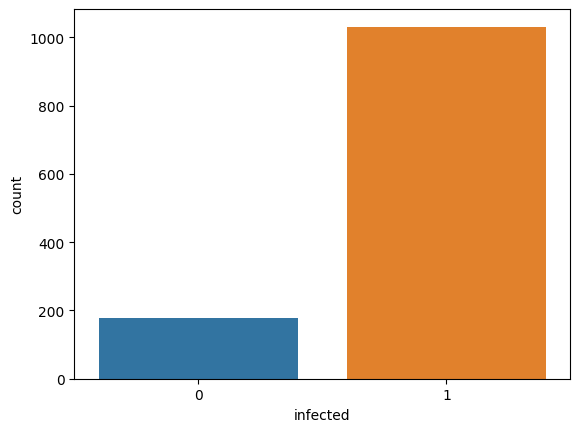

In [15]:
sns.countplot(x = training_json['infected'])

In [16]:
test_json['boxes'] = training_json.objects.apply(objects)

In [17]:
test_json['infected'] = training_json.boxes.apply(infected)

<AxesSubplot:xlabel='infected', ylabel='count'>

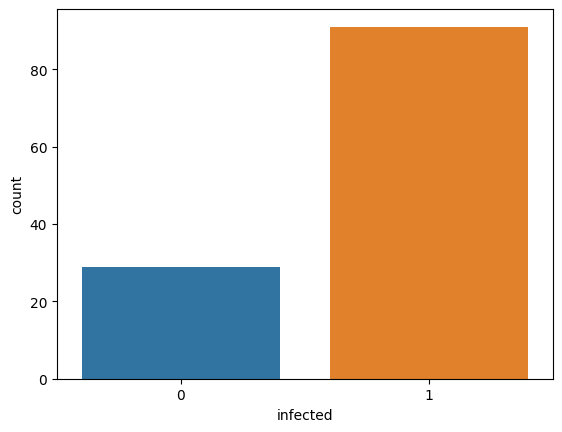

In [18]:
sns.countplot(x = test_json['infected'])

In [19]:
path = img_dircetory = os.path.join('..', 'data', 'Binary_model', 'Images', 'malaria')

In [20]:
def getpath(col):
    return path+col['pathname']

In [21]:
#PIL.Image.open(path+training_json.image[0]['pathname'])

In [22]:
training_json['image_path'] = training_json.image.apply(getpath)

In [23]:
test_json['image_path'] = test_json.image.apply(getpath)

In [24]:
def parsite_num(lis):
    st = 0
    for item in lis:
        if item=='red blood cell':
            st = st+0
        elif item=='leukocytes':
            st = st+0
        else:
            st = st+1
            
    return st

In [25]:
training_json['number_parasite'] = training_json.boxes.apply(parsite_num)

In [26]:
test_json['number_parasite'] = test_json.boxes.apply(parsite_num)

# Defining training and testing sets

In [27]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

2023-05-26 15:53:44.097289: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-26 15:53:44.241154: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-26 15:53:44.242186: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-26 15:53:44.990583: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [28]:
def load_and_preprocess_image(image_path, target_size):
    # Load the image using PIL (Python Imaging Library)
    image = load_img(image_path, target_size=target_size)
    
    # Convert the image to a NumPy array
    image_array = img_to_array(image)
    
    # Preprocess the image (e.g., normalize pixel values)
    preprocessed_image = tf.keras.applications.resnet50.preprocess_input(image_array)
    
    return preprocessed_image

In [29]:
training_image_paths = list(training_json['image_path'])
target_size = (250, 250)  # Set your desired image size

# Create an empty list to store the preprocessed images
training_preprocessed_images = []

# Iterate through the image paths
for training_image_path in training_image_paths:
    training_preprocessed_image = load_and_preprocess_image(training_image_path, target_size)
    training_preprocessed_images.append(training_preprocessed_image)

In [30]:
def normalize_image(image):
    min_val = np.min(image)
    max_val = np.max(image)
    
    
    # Perform min-max normalization
    normalized_image = (image - min_val) / (max_val - min_val)
    
    
    return normalized_image

In [30]:
normalized_images = []

for image in training_preprocessed_images:
    normalized_images.append(normalize_image(image))

In [31]:
X_train = tf.convert_to_tensor(normalized_images)

2023-05-26 13:41:15.061004: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-26 13:41:15.063856: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-26 13:41:15.063909: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-05-26 13:41:15.063941: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-05-26 13:41:15.063972: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

In [62]:
test_image_paths = list(test_json['image_path'])

# Create an empty list to store the preprocessed images
test_preprocessed_images = []

# Iterate through the image paths
for test_image_path in test_image_paths:
    test_preprocessed_image = load_and_preprocess_image(test_image_path, target_size)
    test_preprocessed_images.append(test_preprocessed_image)

In [63]:
test_normalized_images = []

for image in test_preprocessed_images:
    test_normalized_images.append(normalize_image(image))

In [64]:
X_test = tf.convert_to_tensor(test_normalized_images)

In [65]:
y_train = training_json.infected

In [66]:
y_test = test_json.infected

# Model building - Imbalanced Data

In [31]:
from tensorflow.keras import models, layers, regularizers

from tensorflow.keras.callbacks import EarlyStopping

In [161]:
model = models.Sequential()


model.add(layers.Conv2DTranspose(filters = 4, kernel_size = 4, activation = 'relu', input_shape = (250, 250, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Conv2DTranspose(filters = 8, kernel_size = 4, activation = 'relu'))
#model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Conv2DTranspose(filters = 16, kernel_size = 3, activation = 'relu'))
#model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Conv2DTranspose(filters = 32, kernel_size = 2, activation = 'relu'))
#model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Conv2DTranspose(filters = 64, kernel_size = 2, activation = 'relu'))
#model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Conv2DTranspose(filters = 128, kernel_size = 2, activation = 'relu'))
#model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.MaxPool2D(pool_size=(2,2)))


model.add(layers.Flatten())

model.add(layers.Dense(10, activation = 'relu'))

model.add(layers.Dense(1, activation = 'sigmoid'))


In [156]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_82 (Conv2D  (None, 258, 258, 4)      196       
 Transpose)                                                      
                                                                 
 batch_normalization_58 (Bat  (None, 258, 258, 4)      16        
 chNormalization)                                                
                                                                 
 dropout_82 (Dropout)        (None, 258, 258, 4)       0         
                                                                 
 max_pooling2d_77 (MaxPoolin  (None, 129, 129, 4)      0         
 g2D)                                                            
                                                                 
 conv2d_transpose_83 (Conv2D  (None, 132, 132, 8)      520       
 Transpose)                                          

In [162]:
model.compile(optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'Recall', tf.keras.metrics.AUC()])

In [163]:
es = EarlyStopping(monitor='val_loss',
    patience=5,
    restore_best_weights=True)

In [164]:
history = model.fit(x=X_train,
    y=y_train,
    epochs=20,
    verbose='auto',
    callbacks=[es],
    validation_split=0.3)

Epoch 1/20
27/27 [==============================] - 14s 492ms/step - loss: 0.5562 - accuracy: 0.7775 - recall: 0.9549 - auc_18: 0.4626 - val_loss: 0.6010 - val_accuracy: 0.9477 - val_recall: 1.0000 - val_auc_18: 0.7760
Epoch 2/20
27/27 [==============================] - 16s 583ms/step - loss: 0.4738 - accuracy: 0.8130 - recall: 1.0000 - auc_18: 0.5916 - val_loss: 0.5440 - val_accuracy: 0.9477 - val_recall: 1.0000 - val_auc_18: 0.7325
Epoch 3/20
27/27 [==============================] - 13s 481ms/step - loss: 0.4556 - accuracy: 0.8130 - recall: 1.0000 - auc_18: 0.6698 - val_loss: 0.4760 - val_accuracy: 0.9477 - val_recall: 1.0000 - val_auc_18: 0.7106
Epoch 4/20
27/27 [==============================] - 13s 493ms/step - loss: 0.4472 - accuracy: 0.8130 - recall: 1.0000 - auc_18: 0.6894 - val_loss: 0.3883 - val_accuracy: 0.9477 - val_recall: 1.0000 - val_auc_18: 0.7003
Epoch 5/20
27/27 [==============================] - 13s 486ms/step - loss: 0.4392 - accuracy: 0.8130 - recall: 1.0000 - auc_

In [168]:
def plot_loss_auc(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,9))

    # --- LOSS --- 

    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])

    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')

    ax[0].set_ylim((0,1))

    ax[0].legend(['Train', 'Test'], loc='best')

    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)

    # --- ACCURACY

    ax[1].plot(history.history['auc'])
    ax[1].plot(history.history['val_auc'])

    ax[1].set_title('Model auc')
    ax[1].set_ylabel('auc')
    ax[1].set_xlabel('Epoch')

    ax[1].legend(['Train', 'Test'], loc='best')

    ax[1].set_ylim((0,1))

    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    if title:
        fig.suptitle(title)

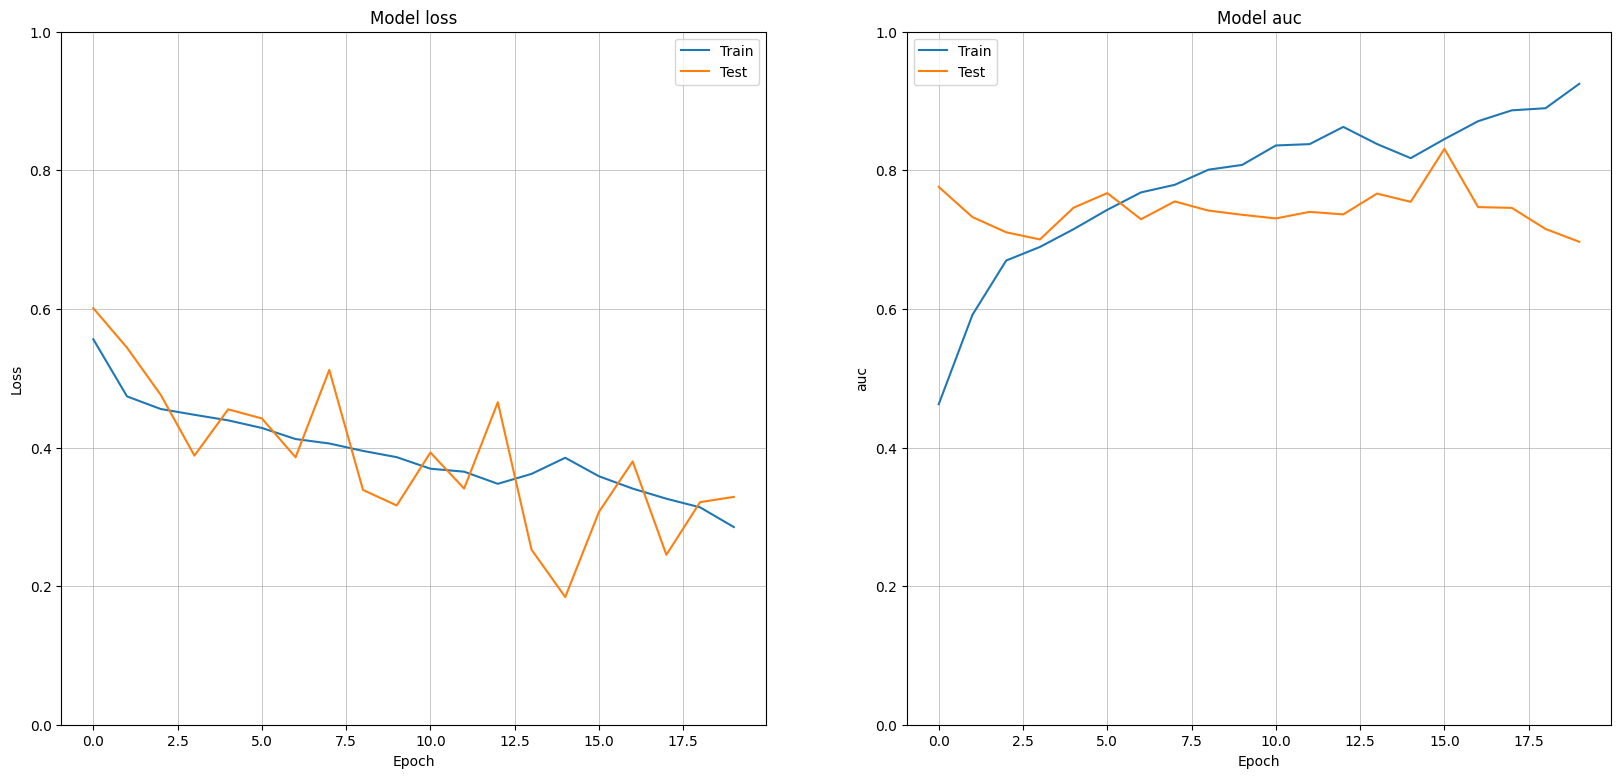

In [169]:
plot_loss_accuracy(history)

In [237]:
model.save('my_2nd_model.h5')

In [165]:
model.evaluate(x=X_test_normalized,
    y=y_test)

4/4 [==============================] - 1s 180ms/step - loss: 0.8658 - accuracy: 0.7583 - recall: 1.0000 - auc_18: 0.4998


[0.8657809495925903, 0.7583333253860474, 1.0, 0.4998105764389038]

# Data Balance

In [38]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [39]:
datagen = ImageDataGenerator(
    zoom_range=0.2,
    brightness_range=(0.8, 1.3))

# Generate augmented samples for the minority class
minority_indices = np.where(y_train == 0)[0]
augmented_images = []
augmented_labels = []

In [40]:
for idx in minority_indices:
    img = training_preprocessed_images[idx]
    img = img.reshape((1,) + img.shape)
    num_augmented_samples = 5  # Number of augmented samples per original sample

    # Generate augmented samples
    for _ in range(num_augmented_samples):
        augmented_img = next(datagen.flow(img))
        augmented_images.append(augmented_img[0])
        augmented_labels.append(y_train[idx])

# Convert augmented data to numpy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Concatenate augmented data with original data
training_preprocessed_images_balanced = np.concatenate((training_preprocessed_images, augmented_images), axis=0)
y_train_balanced = np.concatenate((y_train, augmented_labels), axis=0)

# Shuffle the balanced data
shuffle_indices = np.random.permutation(len(training_preprocessed_images_balanced))
training_preprocessed_images_balanced = training_preprocessed_images_balanced[shuffle_indices]
y_train_balanced = y_train_balanced[shuffle_indices]

In [42]:
balanced_normalized_images = []

for image in training_preprocessed_images_balanced:
    balanced_normalized_images.append(normalize_image(image))

In [43]:
X_train_balanced = tf.convert_to_tensor(balanced_normalized_images)

2023-05-26 16:01:20.660032: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-26 16:01:20.663667: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [74]:
len(balanced_normalized_images)

2093

# Model building - Balanced Data

In [109]:
reg_l2 = regularizers.L2(0.01)

reg_l1_l2 = regularizers.l1_l2(l1=0.005, l2=0.005)


model_balanced = models.Sequential()


model_balanced.add(layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu', input_shape = (250, 250, 3)))
model_balanced.add(layers.BatchNormalization())
model_balanced.add(layers.MaxPool2D(pool_size=(2,2)))


model_balanced.add(layers.Conv2D(filters = 64, kernel_size = 3, activation = 'relu'))
model_balanced.add(layers.BatchNormalization())
model_balanced.add(layers.MaxPool2D(pool_size=(2,2)))

model_balanced.add(layers.Conv2D(filters = 128, kernel_size = 2, activation = 'relu'))
model_balanced.add(layers.BatchNormalization())
model_balanced.add(layers.MaxPool2D(pool_size=(2,2)))


model_balanced.add(layers.Conv2D(filters = 256, kernel_size = 2, activation = 'relu'))
model_balanced.add(layers.BatchNormalization())
model_balanced.add(layers.MaxPool2D(pool_size=(2,2)))


#model_balanced.add(layers.Dropout(0.5))



model_balanced.add(layers.Flatten())

model_balanced.add(layers.Dense(128, activation = 'relu'))

model_balanced.add(layers.Dense(32, activation = 'relu'))

model_balanced.add(layers.Dense(8, activation = 'relu'))



model_balanced.add(layers.Dense(1, activation = 'sigmoid'))

In [110]:
model_balanced.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 248, 248, 32)      896       
                                                                 
 batch_normalization_18 (Bat  (None, 248, 248, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 124, 124, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 122, 122, 64)      18496     
                                                                 
 batch_normalization_19 (Bat  (None, 122, 122, 64)     256       
 chNormalization)                                                
                                                      

In [111]:
model_balanced.compile(optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'Recall', 'Precision'])

In [112]:
es = EarlyStopping(monitor='val_loss',
    patience=5,
    restore_best_weights=True)

In [113]:
history_balanced = model_balanced.fit(x=X_train_balanced,
    y=y_train_balanced,
    batch_size = 16,
    epochs=30,
    verbose='auto',
    callbacks=[es],
    validation_split=0.3)

Epoch 1/30
92/92 [==============================] - 39s 416ms/step - loss: 0.9275 - accuracy: 0.5911 - recall: 0.5305 - precision: 0.5956 - val_loss: 1.0061 - val_accuracy: 0.5032 - val_recall: 0.8382 - val_precision: 0.4971
Epoch 2/30
92/92 [==============================] - 39s 425ms/step - loss: 0.5181 - accuracy: 0.7433 - recall: 0.7452 - precision: 0.7370 - val_loss: 0.9123 - val_accuracy: 0.5032 - val_recall: 0.9935 - val_precision: 0.4976
Epoch 3/30
92/92 [==============================] - 39s 424ms/step - loss: 0.3149 - accuracy: 0.8655 - recall: 0.8740 - precision: 0.8562 - val_loss: 0.7665 - val_accuracy: 0.5175 - val_recall: 0.0421 - val_precision: 0.6500
Epoch 4/30
92/92 [==============================] - 41s 448ms/step - loss: 0.2410 - accuracy: 0.9024 - recall: 0.8934 - precision: 0.9072 - val_loss: 2.2414 - val_accuracy: 0.5080 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 5/30
92/92 [==============================] - 41s 443ms/step - loss: 0.1499 - accuracy

In [100]:
model_balanced.evaluate(x=X_test,
    y=y_test)


4/4 [==============================] - 5s 104ms/step - loss: 3.1365 - accuracy: 0.7417 - recall: 0.9780 - precision: 0.7542


[3.136486530303955, 0.7416666746139526, 0.9780219793319702, 0.7542372941970825]

In [108]:
model_balanced.save('3rd_balanced_model.h5')

In [106]:
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,9))

    # --- LOSS --- 

    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])

    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')

    ax[0].set_ylim((0,10))

    ax[0].legend(['Train', 'Test'], loc='best')

    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)

    # --- ACCURACY

    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])

    ax[1].set_title('Model accuracy')
    ax[1].set_ylabel('accuracy')
    ax[1].set_xlabel('Epoch')

    ax[1].legend(['Train', 'Test'], loc='best')

    ax[1].set_ylim((0,1.2))

    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    if title:
        fig.suptitle(title)

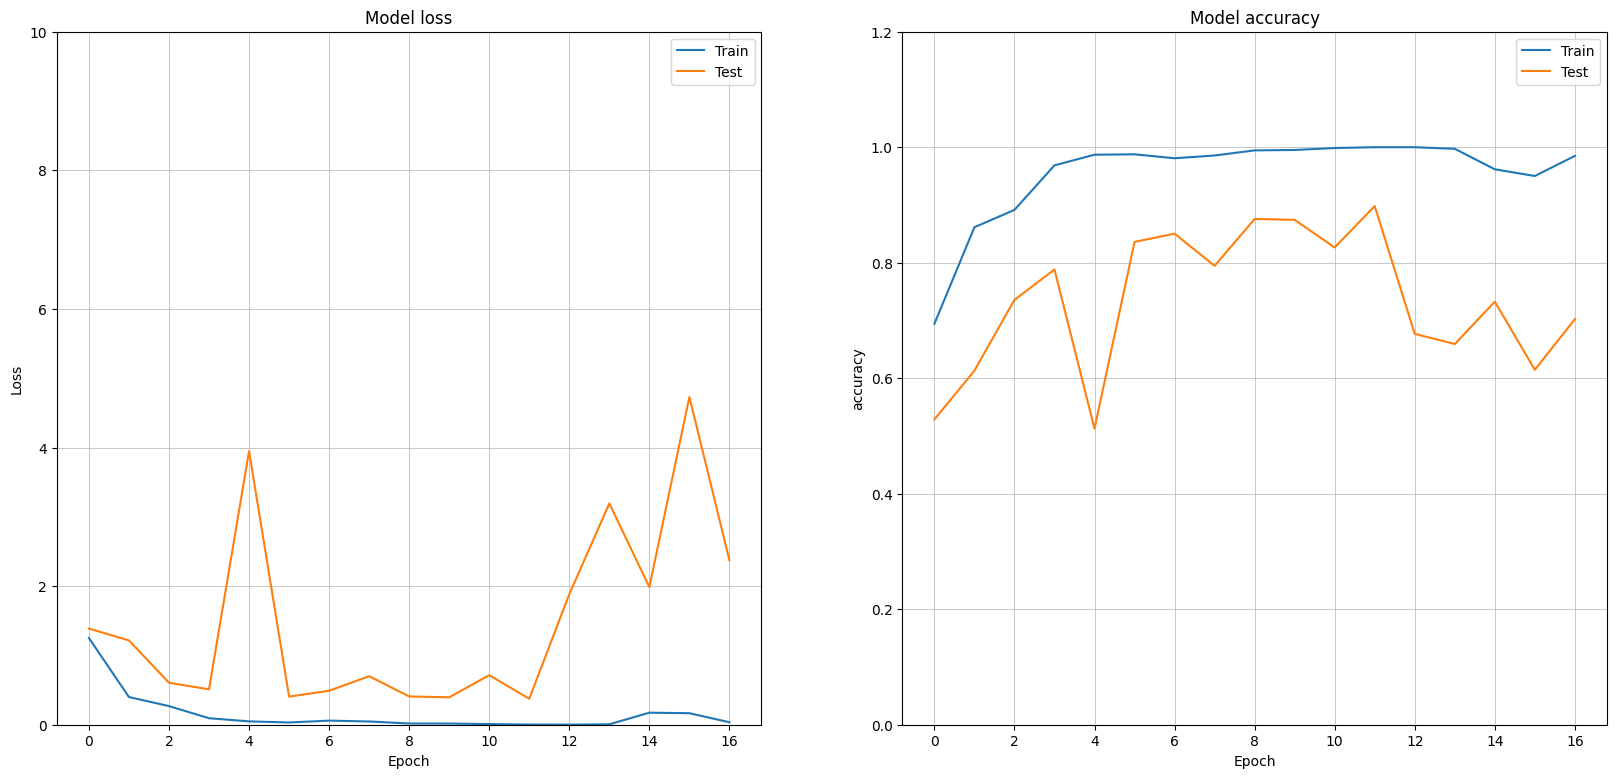

In [107]:
plot_loss_accuracy(history_balanced)

In [67]:
model_balanced.predict(X_test)

4/4 [==============================] - 0s 93ms/step


array([[9.5277435e-01],
       [9.9896425e-01],
       [9.9872774e-01],
       [9.9992424e-01],
       [9.9996859e-01],
       [4.4491622e-01],
       [9.9967694e-01],
       [9.9994481e-01],
       [9.9901778e-01],
       [9.9717444e-01],
       [9.9032903e-01],
       [5.0265700e-01],
       [9.9993664e-01],
       [9.5746815e-01],
       [9.9999213e-01],
       [9.9998492e-01],
       [9.9993551e-01],
       [9.9999964e-01],
       [9.9997830e-01],
       [9.9940699e-01],
       [9.9999291e-01],
       [9.9057591e-01],
       [9.9215472e-01],
       [9.9971849e-01],
       [9.7206628e-01],
       [9.9979544e-01],
       [9.9983573e-01],
       [9.9939048e-01],
       [9.9980044e-01],
       [7.6398456e-01],
       [9.9999291e-01],
       [9.9428916e-01],
       [9.9972874e-01],
       [9.9961561e-01],
       [1.9133945e-06],
       [9.9989998e-01],
       [9.9538386e-01],
       [9.9924940e-01],
       [9.9929136e-01],
       [9.9990249e-01],
       [9.9904943e-01],
       [9.999690

In [120]:
y_test

0      1
1      0
2      1
3      1
4      1
      ..
115    1
116    1
117    1
118    0
119    1
Name: infected, Length: 120, dtype: int64

In [53]:
final_model = models.load_model('2nd_balanced_model.h5')

In [54]:
final_model.predict(X_test)

4/4 [==============================] - 0s 40ms/step


array([[0.49215278],
       [0.493008  ],
       [0.492832  ],
       [0.49268413],
       [0.49275702],
       [0.4925212 ],
       [0.49253127],
       [0.49281985],
       [0.49345276],
       [0.49324566],
       [0.491808  ],
       [0.49251977],
       [0.49313435],
       [0.49298814],
       [0.49328014],
       [0.49277908],
       [0.49287608],
       [0.49307793],
       [0.49351877],
       [0.49332207],
       [0.49323288],
       [0.4926463 ],
       [0.4922762 ],
       [0.49344966],
       [0.49317783],
       [0.49312592],
       [0.492703  ],
       [0.49314094],
       [0.49254844],
       [0.49292326],
       [0.49314347],
       [0.49341246],
       [0.49295986],
       [0.493098  ],
       [0.4930599 ],
       [0.49301982],
       [0.49274626],
       [0.49267936],
       [0.49325112],
       [0.49255955],
       [0.49279365],
       [0.49321768],
       [0.49351895],
       [0.49343887],
       [0.49322996],
       [0.49304467],
       [0.49248785],
       [0.493